In [12]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import os

In [13]:
def load_and_prepare_data(data):
    """
    Prepare the data for analysis by converting it to long format
    """
    # Melt the dataframe to get it in long format
    id_vars = ['Participant_ID', 'Group_ID']
    value_vars = [col for col in data.columns if col not in id_vars]
    df_long = data.melt(id_vars=id_vars, value_vars=value_vars, 
                       var_name='Task', value_name='Time')
    
    # Add session information
    def get_session(task):
        if task in ['T0', 'P1', 'T1']:
            return 'S1'
        elif task in ['P2', 'T2']:
            return 'S2'
        elif task in ['P3', 'T3']:
            return 'S3'
        elif task in ['P4', 'T4']:
            return 'S4'
        else:
            return 'S5'
    
    df_long['Session'] = df_long['Task'].apply(get_session)
    df_long['TaskType'] = df_long['Task'].apply(lambda x: 'Practice' if x.startswith('P') else 'Test')
    
    return df_long


In [14]:
# Load and prepare data
data_path_time = os.path.join('SpringTime.csv')
data_path_correctness = os.path.join('SpringCorrectness.csv')

time_data = pd.read_csv(data_path_time)
correctness_data = pd.read_csv(data_path_correctness)

time_long = load_and_prepare_data(time_data)
correctness_long = load_and_prepare_data(correctness_data)

# Filter for test tasks only
time_tests = time_long[time_long['Task'].str.startswith('T')]
correctness_tests = correctness_long[correctness_long['Task'].str.startswith('T')]


In [15]:
# Create combined performance table
combined_performance = pd.DataFrame()

for group_id in range(1, 5):
    group_time = time_tests[time_tests['Group_ID'] == group_id]
    group_correctness = correctness_tests[correctness_tests['Group_ID'] == group_id]
    test_tasks = ['T0', 'T1', 'T2', 'T3', 'T4', 'T5']
    
    # Get mean time and success rate for each task
    time_means = group_time.groupby('Task')['Time'].mean().round(2)
    success_rates = group_correctness.groupby('Task')['Time'].mean().round(2)
    
    # Combine into a single row per task
    for task in test_tasks:
        row_data = {
            'Group': group_id,
            'Task': task,
            'Mean_Time': time_means.get(task, np.nan),
            'Success_Rate': success_rates.get(task, np.nan)
        }
        combined_performance = pd.concat([combined_performance, pd.DataFrame([row_data])])

# Reset index and sort
combined_performance = combined_performance.reset_index(drop=True)
combined_performance = combined_performance.sort_values(['Group', 'Task'])

# Reshape the data to show trends more clearly
time_trends = combined_performance.pivot(index='Group', columns='Task', values='Mean_Time').round(2)
time_trends.columns.name = 'Test Tasks'
time_trends.index.name = 'Group'

success_trends = combined_performance.pivot(index='Group', columns='Task', values='Success_Rate').round(2)
success_trends.columns.name = 'Test Tasks'
success_trends.index.name = 'Group'

# Add trend indicators
def calculate_trend(row):
    first_valid = row.first_valid_index()
    last_valid = row.last_valid_index()
    if pd.notna(row[first_valid]) and pd.notna(row[last_valid]):
        change = ((row[last_valid] - row[first_valid]) / row[first_valid] * 100).round(2)
        return change
    return np.nan

time_trends['Overall_Change_%'] = time_trends.apply(lambda row: calculate_trend(row), axis=1)
success_trends['Overall_Change_%'] = success_trends.apply(lambda row: 
    (row[row.last_valid_index()] - row[row.first_valid_index()]) * 100 
    if pd.notna(row[row.first_valid_index()]) and pd.notna(row[row.last_valid_index()]) 
    else np.nan, axis=1)

print("Time Completion Trends (minutes)")
print("===============================")
print(time_trends)
print("\nNegative Overall_Change_% means participants got faster")

print("\nSuccess Rate Trends")
print("==================")
print(success_trends)
print("\nPositive Overall_Change_% means participants improved accuracy")

Time Completion Trends (minutes)
Test Tasks     T0     T1     T2     T3     T4     T5  Overall_Change_%
Group                                                                 
1           41.09  26.58  22.28  22.72  22.81  31.27            -23.90
2           34.21  31.17  23.34  24.59  21.79  21.86            -36.10
3           37.77  27.22  24.04  27.15  27.36  22.45            -40.56
4           39.30  13.48  14.77  14.08  12.83  13.59            -65.42

Negative Overall_Change_% means participants got faster

Success Rate Trends
Test Tasks    T0    T1    T2    T3    T4    T5  Overall_Change_%
Group                                                           
1           0.33  0.22  0.56  0.56  0.56  0.38               5.0
2           0.40  0.20  0.50  0.44  0.56  0.44               4.0
3           0.33  0.44  0.67  0.67  0.44  0.44              11.0
4           0.30  0.80  0.90  0.80  0.90  0.80              50.0

Positive Overall_Change_% means participants improved accuracy


set the figures format and colors

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Create output directory if it doesn't exist
os.makedirs('../output_figures/', exist_ok=True)

# Set style
plt.style.use('seaborn')

# Define colorblind-friendly colors
colors = ['#E69F00',  # orange
          '#56B4E9',  # light blue 
          '#009E73',  # green
          '#CC79A7']  # pink

# Define markers for each group
markers = ['o',    # circle
          '^',    # triangle up 
          's',    # square
          'D']    # diamond

# Define different line styles for average lines
avg_styles = [(0, (1, 1)),      # dotted
              (0, (5, 5)),      # dashed
              (0, (3, 1, 1, 1)), # dash-dot
              (0, (8, 5))]      # long dash

# Define line properties for average lines
linewidth_avg = 3.5  # Increased linewidth for average lines
alpha_avg = 0.8      # Increased opacity for better visibility

# Define the order we want
groups_order = [(0, 'G1'), 
                (1, 'G2'),
                (2, 'G3'),
                (3, 'G4')]

# Define positions for each task label based on the specified units
positions = {
    'T0': 0,
    'P1': 1,    # T0->P1: 1 unit
    'T1': 2,    # P1->T1: 1 unit
    'P2': 4,    # T1->P2: 2 units
    'T2': 5,    # P2->T2: 1 unit
    'P3': 7,    # T2->P3: 2 units
    'T3': 8,    # P3->T3: 1 unit
    'P4': 10,   # T3->P4: 2 units
    'T4': 11,   # P4->T4: 1 unit
    'P5': 16,   # T4->P5: 5 units
    'T5': 17,   # P5->T5: 1 unit
}

# Modified x-axis ticks and labels
tasks = ['T0', 'P1', 'T1', 'P2', 'T2', 'P3', 'T3', 'P4', 'T4', 'P5', 'T5']
test_tasks = ['T0', 'T1', 'T2', 'T3', 'T4', 'T5']  # Original tasks for data plotting
practice_tasks = ['P1', 'P2', 'P3', 'P4', 'P5']  # practices

# Define sessions and weeks information
# Calculate center position for each session
session_positions = {
    'Session 1 (w1)': (positions['T0'] + positions['T1']) / 2,  # Center of T0-T1
    'Session 2 (w2)': (positions['P2'] + positions['T2']) / 2,  # Center of P2-T2
    'Session 3 (w3)': (positions['P3'] + positions['T3']) / 2,  # Center of P3-T3
    'Session 4 (w4)': (positions['P4'] + positions['T4']) / 2,  # Center of P4-T4
    'Session 5 (w8)': (positions['P5'] + positions['T5']) / 2,  # Center of P5-T5
}

session_colors = ['#E6E6FA',  # Session 1: Lavender
                  '#F0FFF0',  # Session 2: Honeydew
                  '#F5F5F5',  # Session 3: Whitesmoke
                  '#FFFAF0',  # Session 4: Floral White
                  '#F5DEB3']  # Session 5: Wheat

<ipython-input-16-9f922c77c053>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


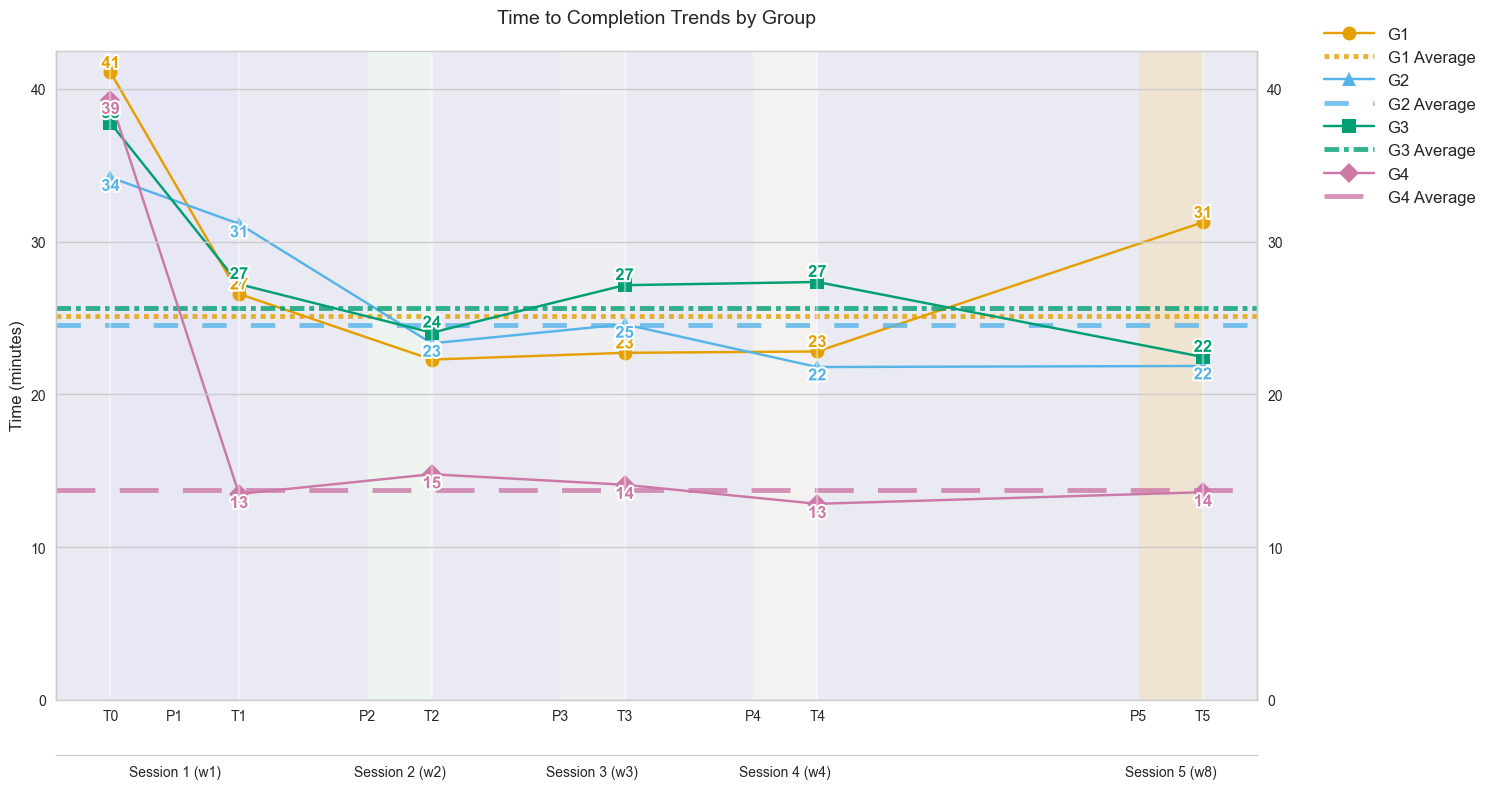

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import matplotlib.patheffects as pe

# Plot 1: Time trends
fig, ax1 = plt.subplots(figsize=(15, 8))
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# Create twin axis
ax2 = ax1.twinx()

# Define offsets for annotations to prevent overlapping
y_offsets = [1, -1, 1.5, -1.5]  # Different offsets for each group


# Plot lines in our desired order
for idx, (i, group_name) in enumerate(groups_order):
    time_data = time_trends.loc[i+1]  # +1 because groups are 1-based
    values = time_data[test_tasks]
    
        # Main line with markers
    line = ax1.plot([positions[t] for t in test_tasks],  # Use positions dictionary
                    values,
                    marker=markers[i],
                    label=group_name,
                    color=colors[i],
                    markersize=10)[0]
    
    # Add value annotations
    for x, y in zip([positions[t] for t in test_tasks], values):
        ax1.annotate(f'{y:.0f}',
                    (x, y),
                    textcoords="offset points",
                    xytext=(0, y_offsets[idx]),
                    ha='center',
                    va='bottom' if y_offsets[idx] > 0 else 'top',
                    color=colors[i],
                    fontsize=12,
                    fontweight='bold',
                    path_effects=[pe.withStroke(linewidth=3, foreground='white')],
                    )
    
    # Average line
    avg_time = time_data[['T1', 'T2', 'T3', 'T4', 'T5']].mean()
    avg_line = ax1.axhline(y=avg_time, 
                          color=colors[i], 
                          linestyle=avg_styles[i], 
                          alpha=alpha_avg,
                          linewidth=linewidth_avg,
                          label=f"{group_name} Average")

# Set up primary axis (left)
ax1.set_title('Time to Completion Trends by Group', pad=20, fontsize=14)
#ax1.grid(True)
ax1.yaxis.grid(True, linestyle='-', alpha=0.2)
# Explicitly turn off all grid lines
ax1.grid(False)

# Add vertical grid lines only for T0 - T5
for i, task in enumerate(test_tasks):
    ax1.axvline(x=positions[task], color='white', linestyle='-', alpha=0.4)




# Set x-axis ticks and labels using all positions
# ax1.set_xlabel('Tasks', fontsize=12)
ax1.set_xticks(list(positions.values()))
ax1.set_xticklabels(tasks)
# Add background color based on session
for session, session_pos in session_positions.items():
    if session == 'Session 1 (w1)':
        ax1.axvspan(0, positions['T1'], facecolor='#E6E6FA', alpha=0.5) # Lavender
    elif session == 'Session 2 (w2)':
        ax1.axvspan(positions['P2'], positions['T2'], facecolor='#F0FFF0', alpha=0.5) # Honeydew
    elif session == 'Session 3 (w3)':
        ax1.axvspan(positions['P3'], positions['T3'], facecolor='#F5F5F5', alpha=0.5) # Whitesmoke
    elif session == 'Session 4 (w4)':
        ax1.axvspan(positions['P4'], positions['T4'], facecolor='#FFFAF0', alpha=0.5) # Floral White
    elif session == 'Session 5 (w8)':
        ax1.axvspan(positions['P5'], positions['T5'], facecolor='#F5DEB3', alpha=0.5) # Wheat

# Add a second x-axis for session labels
ax3 = ax1.twiny()
ax3.grid(False)
ax3.set_xlim(ax1.get_xlim())
ax3.set_xticks(list(session_positions.values()))  # Use center positions
ax3.set_xticklabels(list(session_positions.keys()))  # Add session labels

# Adjust position of the second x-axis to be below the main one
ax3.spines['bottom'].set_position(('outward', 40))
# ax3.xaxis.set_tick_params(rotation=45)

# Make sure the top spine and ticks are invisible
ax3.spines['top'].set_visible(False)
ax3.xaxis.set_ticks_position('bottom')



# Set y-axis ticks and labels
ax1.set_ylabel('Time (minutes)', fontsize=12)
ax1.set_yticks(range(0, 45, 10))

# Set up secondary axis (right)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(ax1.get_yticks())
ax2.set_yticklabels(ax1.get_yticks())

# Create legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels,
          fontsize=12,
          ncol=1,
          loc='center left',
          bbox_to_anchor=(1.05, 0.9),
          handlelength=3,
          borderaxespad=0.)

plt.tight_layout()

# Save the first figure
plt.savefig('../output_figures/time_trends_by_group.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white')
plt.show()
plt.close()


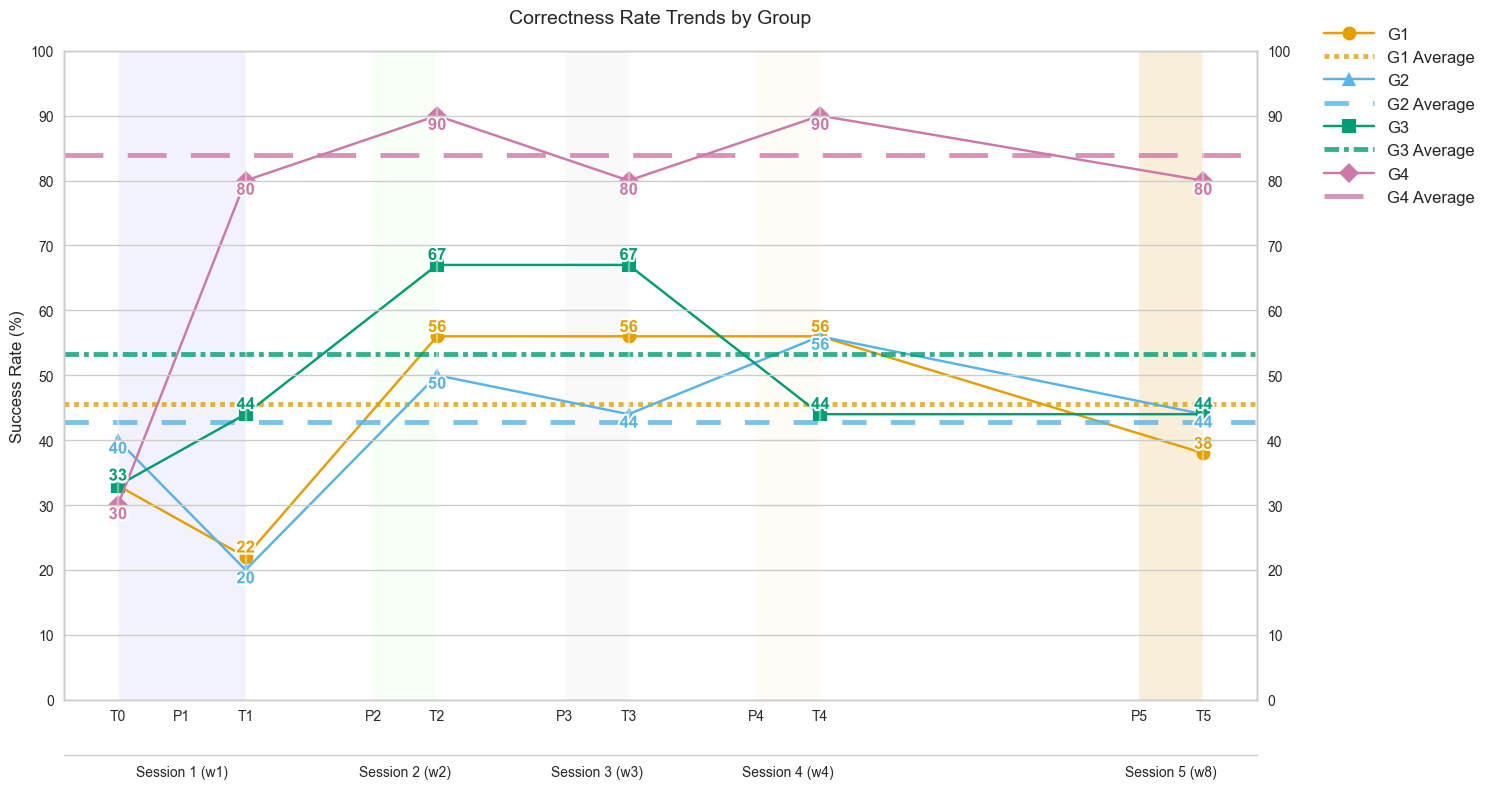

In [18]:

# Plot 2: Success rate trends
fig, ax1 = plt.subplots(figsize=(15, 8))
# Create twin axis
ax2 = ax1.twinx()

# Plot lines in our desired order
for idx, (i, group_name) in enumerate(groups_order):
    success_data = success_trends.loc[i+1]
    values = success_data[test_tasks]
    
    # Main line with markers
    line = ax1.plot([positions[t] for t in test_tasks],  # Use positions dictionary
                    values,
                    marker=markers[i],
                    label=group_name,
                    color=colors[i],
                    markersize=10)[0]
    
    # Add value annotations
    for x, y in zip([positions[t] for t in test_tasks], values):
        ax1.annotate(f'{y*100:.0f}',
                    (x, y),
                    textcoords="offset points",
                    xytext=(0, y_offsets[idx]),
                    ha='center',
                    va='bottom' if y_offsets[idx] > 0 else 'top',
                    color=colors[i],
                    fontsize=12,
                    fontweight='bold',
                    path_effects=[pe.withStroke(linewidth=3, foreground='white')],
                    )
    
    # Average line
    avg_success = success_data[['T1', 'T2', 'T3', 'T4', 'T5']].mean()
    avg_line = ax1.axhline(y=avg_success, 
                          color=colors[i], 
                          linestyle=avg_styles[i], 
                          alpha=alpha_avg,
                          linewidth=linewidth_avg,
                          label=f"{group_name} Average")

# Set up primary axis (left)
ax1.set_title('Correctness Rate Trends by Group', pad=20, fontsize=14)
# ax1.set_xlabel('Tasks', fontsize=12)

ax1.yaxis.grid(True, linestyle='-', alpha=0.2)
# Explicitly turn off all grid lines
ax1.grid(False)

# Add vertical grid lines only for T0 - T5
for i, task in enumerate(test_tasks):
    ax1.axvline(x=positions[task], color='white', linestyle='-', alpha=0.4)

# Set x-axis ticks and labels
ax1.set_xticks(list(positions.values()))
ax1.set_xticklabels(tasks)

# Add background color based on session
for session, session_pos in session_positions.items():
    if session == 'Session 1 (w1)':
        ax1.axvspan(0, positions['T1'], facecolor='#E6E6FA', alpha=0.5) # Lavender
    elif session == 'Session 2 (w2)':
        ax1.axvspan(positions['P2'], positions['T2'], facecolor='#F0FFF0', alpha=0.5) # Honeydew
    elif session == 'Session 3 (w3)':
        ax1.axvspan(positions['P3'], positions['T3'], facecolor='#F5F5F5', alpha=0.5) # Whitesmoke
    elif session == 'Session 4 (w4)':
        ax1.axvspan(positions['P4'], positions['T4'], facecolor='#FFFAF0', alpha=0.5) # Floral White
    elif session == 'Session 5 (w8)':
        ax1.axvspan(positions['P5'], positions['T5'], facecolor='#F5DEB3', alpha=0.5) # Wheat




# Add a second x-axis for session labels
ax3 = ax1.twiny()
ax3.grid(False)
ax3.set_xlim(ax1.get_xlim())
ax3.set_xticks(list(session_positions.values()))  # Use center positions
ax3.set_xticklabels(list(session_positions.keys()))  # Add session labels

# Adjust position of the second x-axis to be below the main one
ax3.spines['bottom'].set_position(('outward', 40))
# ax3.xaxis.set_tick_params(rotation=45)

# Make sure the top spine and ticks are invisible
ax3.spines['top'].set_visible(False)
ax3.xaxis.set_ticks_position('bottom')




# Set y-axis ticks and labels
ax1.set_ylabel('Success Rate (%)', fontsize=12)
ax1.set_ylim(0, 1)
ax1.set_yticks([i/10 for i in range(0, 11, 1)])
ax1.set_yticklabels([int(i*10) for i in range(0, 11, 1)])  

# Set up secondary axis (right)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(ax1.get_yticks())
ax2.set_yticklabels([int(i*10) for i in range(0, 11, 1)])


# Create legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels,
          fontsize=12,
          ncol=1,
          loc='center left',
          bbox_to_anchor=(1.05, 0.9),
          handlelength=3,
          borderaxespad=0.)

plt.tight_layout()

# Save the second figure
plt.savefig('../output_figures/correctness_trends_by_group.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white')

plt.show()

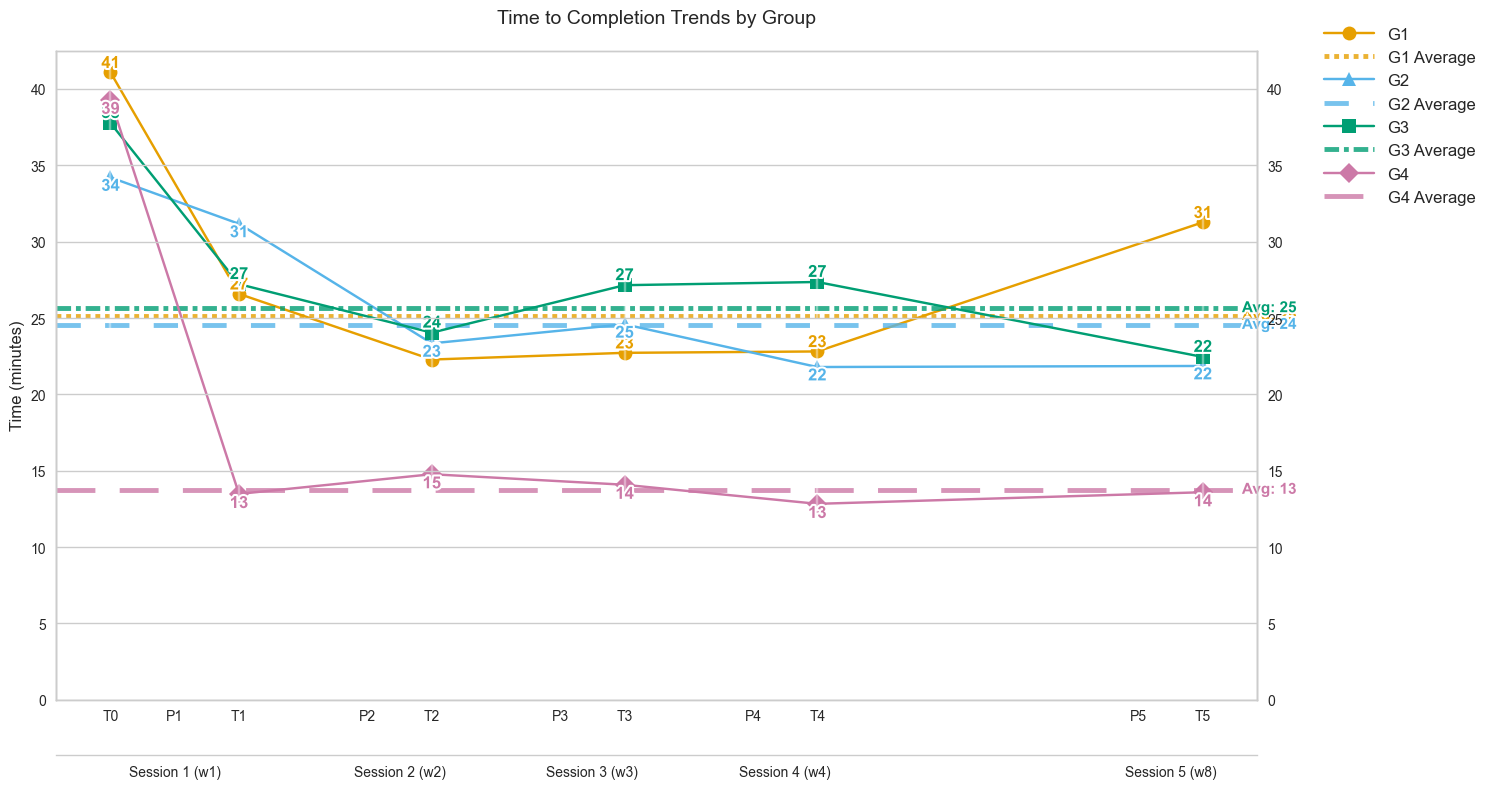

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import matplotlib.patheffects as pe

# Plot 1: Time trends
fig, ax1 = plt.subplots(figsize=(15, 8))
# Create twin axis
ax2 = ax1.twinx()

# Define offsets for annotations to prevent overlapping
y_offsets = [1, -1, 1.5, -1.5]  # Different offsets for each group


# Plot lines in our desired order
for idx, (i, group_name) in enumerate(groups_order):
    time_data = time_trends.loc[i+1]  # +1 because groups are 1-based
    values = time_data[test_tasks]
    
        # Main line with markers
    line = ax1.plot([positions[t] for t in test_tasks],  # Use positions dictionary
                    values,
                    marker=markers[i],
                    label=group_name,
                    color=colors[i],
                    markersize=10)[0]
    
    # Add value annotations
    for x, y in zip([positions[t] for t in test_tasks], values):
        ax1.annotate(f'{y:.0f}',
                    (x, y),
                    textcoords="offset points",
                    xytext=(0, y_offsets[idx]),
                    ha='center',
                    va='bottom' if y_offsets[idx] > 0 else 'top',
                    color=colors[i],
                    fontsize=12,
                    fontweight='bold',
                    path_effects=[pe.withStroke(linewidth=3, foreground='white')],
                    )
    
    # Average line
    avg_time = time_data[['T1', 'T2', 'T3', 'T4', 'T5']].mean()
    avg_line = ax1.axhline(y=avg_time, 
                          color=colors[i], 
                          linestyle=avg_styles[i], 
                          alpha=alpha_avg,
                          linewidth=linewidth_avg,
                          label=f"{group_name} Average")
    
    # Add annotation for the average line
    # Position it at the right side of the plot
    right_edge = max(positions.values()) + 0.5  # A bit beyond the rightmost point
    ax1.annotate(f'Avg: {int(avg_time)}',
                (right_edge, avg_time),
                textcoords="offset points",
                xytext=(5, 0),  # Offset to the right
                ha='left',
                va='center',
                color=colors[i],
                fontsize=11,
                fontweight='bold',
                path_effects=[pe.withStroke(linewidth=3, foreground='white')],
                )

# Set up primary axis (left)
ax1.set_title('Time to Completion Trends by Group', pad=20, fontsize=14)
#ax1.grid(True)
ax1.yaxis.grid(True, linestyle='-', alpha=0.2)
# Explicitly turn off all grid lines
ax1.grid(False)

# Add vertical grid lines only for T0 - T5
for i, task in enumerate(test_tasks):
    ax1.axvline(x=positions[task], color='white', linestyle='-', alpha=0.4)




# Set x-axis ticks and labels using all positions
# ax1.set_xlabel('Tasks', fontsize=12)
ax1.set_xticks(list(positions.values()))
ax1.set_xticklabels(tasks)


# Add a second x-axis for session labels
ax3 = ax1.twiny()
ax3.grid(False)
ax3.set_xlim(ax1.get_xlim())
ax3.set_xticks(list(session_positions.values()))  # Use center positions
ax3.set_xticklabels(list(session_positions.keys()))  # Add session labels

# Adjust position of the second x-axis to be below the main one
ax3.spines['bottom'].set_position(('outward', 40))
# ax3.xaxis.set_tick_params(rotation=45)

# Make sure the top spine and ticks are invisible
ax3.spines['top'].set_visible(False)
ax3.xaxis.set_ticks_position('bottom')






# Set y-axis ticks and labels
ax1.set_ylabel('Time (minutes)', fontsize=12)
ax1.set_yticks(range(0, 45, 5))

# Set up secondary axis (right)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(ax1.get_yticks())
ax2.set_yticklabels(ax1.get_yticks())

# Create legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels,
          fontsize=12,
          ncol=1,
          loc='center left',
          bbox_to_anchor=(1.05, 0.9),
          handlelength=3,
          borderaxespad=0.)

plt.tight_layout()

# Save the first figure
plt.savefig('../output_figures/time_trends_by_group_no_bgc.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white')
plt.show()
plt.close()


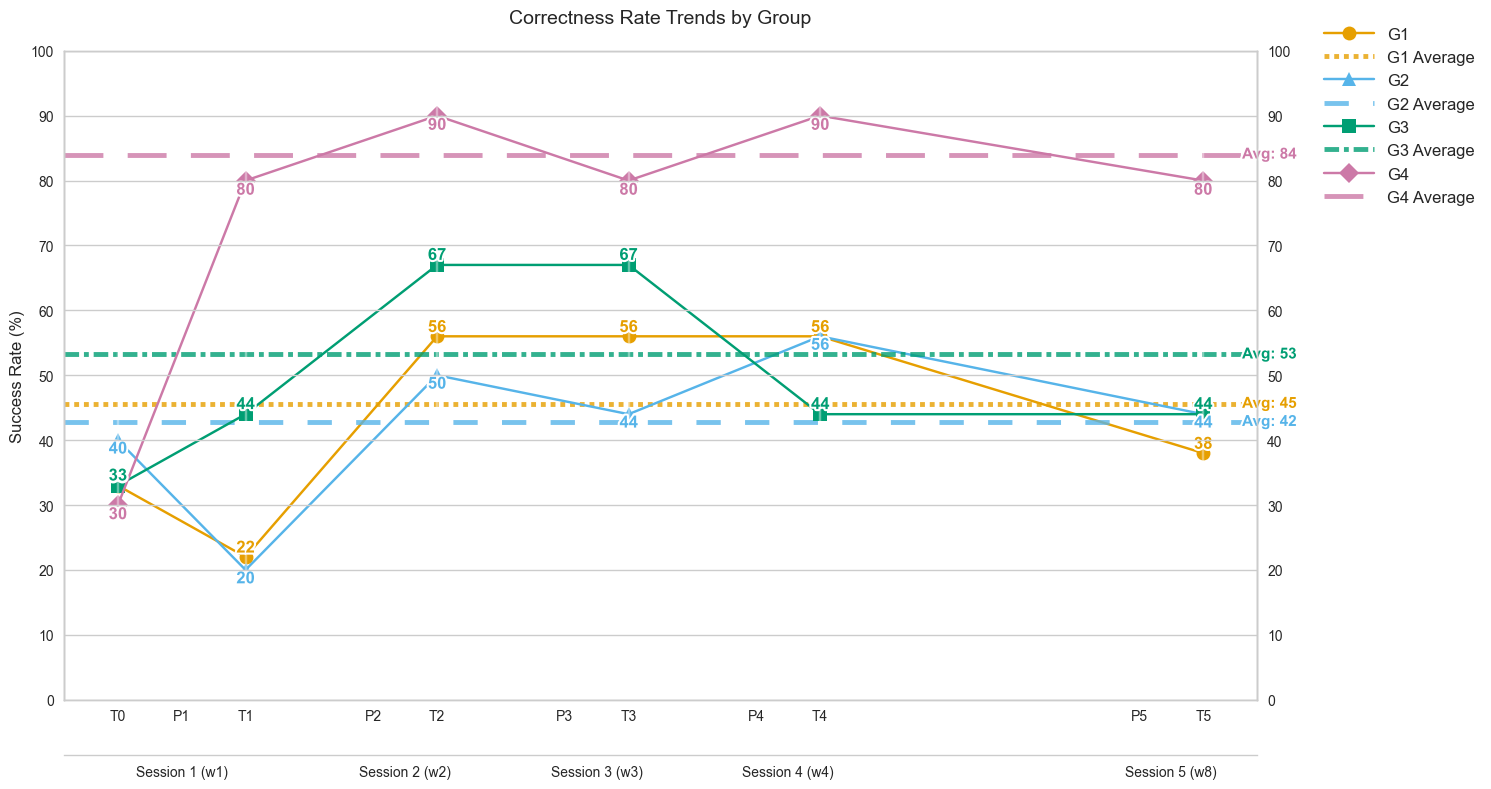

In [20]:

# Plot 2: Success rate trends
fig, ax1 = plt.subplots(figsize=(15, 8))
# Create twin axis
ax2 = ax1.twinx()

# Plot lines in our desired order
for idx, (i, group_name) in enumerate(groups_order):
    success_data = success_trends.loc[i+1]
    values = success_data[test_tasks]
    
    # Main line with markers
    line = ax1.plot([positions[t] for t in test_tasks],  # Use positions dictionary
                    values,
                    marker=markers[i],
                    label=group_name,
                    color=colors[i],
                    markersize=10)[0]
    
    # Add value annotations
    for x, y in zip([positions[t] for t in test_tasks], values):
        ax1.annotate(f'{y*100:.0f}',
                    (x, y),
                    textcoords="offset points",
                    xytext=(0, y_offsets[idx]),
                    ha='center',
                    va='bottom' if y_offsets[idx] > 0 else 'top',
                    color=colors[i],
                    fontsize=12,
                    fontweight='bold',
                    path_effects=[pe.withStroke(linewidth=3, foreground='white')],
                    )
    
    # Average line
    avg_success = success_data[['T1', 'T2', 'T3', 'T4', 'T5']].mean()
    avg_line = ax1.axhline(y=avg_success, 
                          color=colors[i], 
                          linestyle=avg_styles[i], 
                          alpha=alpha_avg,
                          linewidth=linewidth_avg,
                          label=f"{group_name} Average")
    
    # Add annotation for the average line
    # Position it at the right side of the plot
    right_edge = max(positions.values()) + 0.5  # A bit beyond the rightmost point
    ax1.annotate(f'Avg: {int(avg_success*100)}',  # Convert to percentage and display as integer
                (right_edge, avg_success),
                textcoords="offset points",
                xytext=(5, 0),  # Offset to the right
                ha='left',
                va='center',
                color=colors[i],
                fontsize=11,
                fontweight='bold',
                path_effects=[pe.withStroke(linewidth=3, foreground='white')],
                )
    

# Set up primary axis (left)
ax1.set_title('Correctness Rate Trends by Group', pad=20, fontsize=14)
# ax1.set_xlabel('Tasks', fontsize=12)

ax1.yaxis.grid(True, linestyle='-', alpha=0.2)
# Explicitly turn off all grid lines
ax1.grid(False)

# Add vertical grid lines only for T0 - T5
for i, task in enumerate(test_tasks):
    ax1.axvline(x=positions[task], color='white', linestyle='-', alpha=0.4)

# Set x-axis ticks and labels
ax1.set_xticks(list(positions.values()))
ax1.set_xticklabels(tasks)



# Add a second x-axis for session labels
ax3 = ax1.twiny()
ax3.grid(False)
ax3.set_xlim(ax1.get_xlim())
ax3.set_xticks(list(session_positions.values()))  # Use center positions
ax3.set_xticklabels(list(session_positions.keys()))  # Add session labels

# Adjust position of the second x-axis to be below the main one
ax3.spines['bottom'].set_position(('outward', 40))
# ax3.xaxis.set_tick_params(rotation=45)

# Make sure the top spine and ticks are invisible
ax3.spines['top'].set_visible(False)
ax3.xaxis.set_ticks_position('bottom')




# Set y-axis ticks and labels
ax1.set_ylabel('Success Rate (%)', fontsize=12)
ax1.set_ylim(0, 1)
ax1.set_yticks([i/10 for i in range(0, 11, 1)])
ax1.set_yticklabels([int(i*10) for i in range(0, 11, 1)])  

# Set up secondary axis (right)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(ax1.get_yticks())
ax2.set_yticklabels([int(i*10) for i in range(0, 11, 1)])


# Create legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels,
          fontsize=12,
          ncol=1,
          loc='center left',
          bbox_to_anchor=(1.05, 0.9),
          handlelength=3,
          borderaxespad=0.)

plt.tight_layout()

# Save the second figure
plt.savefig('../output_figures/correctness_trends_by_group_no_ngc.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white')

plt.show()